<a href="https://colab.research.google.com/github/TAUforPython/machinelearning/blob/main/GNN%20link%20prediction%20GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
torch.__version__

'2.6.0+cu124'

In [4]:
# Install torch geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
!pip install -q torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 39.9 MB/s eta 0:00:00


In [5]:
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_scatter_cuda.so: undefined symbol: _ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_St8optionalIN3c1017basic_string_viewIcEEE
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_spmm_cuda.so: undefined symbol: _ZN5torch8autograd12VariableInfoC1ERKN2at6TensorE
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [6]:
transform = T.Compose([
    T.NormalizeFeatures(),
    T.RandomLinkSplit(num_val=0.05,
                      num_test=0.1,
                      is_undirected=True,
                      add_negative_train_samples=True),
])
dataset = Planetoid(root="cora", name='CORA', transform=transform)
dataset

Processing...
Done!


CORA()

In [7]:
dataset.num_features

1433

In [8]:
dataset.num_classes

7

In [9]:
dataset[0]

(Data(x=[2708, 1433], edge_index=[2, 8976], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[8976], edge_label_index=[2, 8976]),
 Data(x=[2708, 1433], edge_index=[2, 8976], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[526], edge_label_index=[2, 526]),
 Data(x=[2708, 1433], edge_index=[2, 9502], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[1054], edge_label_index=[2, 1054]))

In [65]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub(transform=transform)
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [66]:
data = dataset[0]
data

(Data(x=[34, 34], edge_index=[2, 136], y=[34], train_mask=[34], edge_label=[136], edge_label_index=[2, 136]),
 Data(x=[34, 34], edge_index=[2, 136], y=[34], train_mask=[34], edge_label=[6], edge_label_index=[2, 6]),
 Data(x=[34, 34], edge_index=[2, 142], y=[34], train_mask=[34], edge_label=[14], edge_label_index=[2, 14]))

## DataLoader

The `Data` splits do not lend themselves to batch level training. For this exercise, we will work with each subgraph in its entirety.

Note that you could create `DataLoaders` from the splits by doing this:

`train_loader = DataLoader([train_dataset], shuffle=True, ...)`

but it will result in a single batch.

Separate the splits into a `train_dataset`, `val_dataset` and `test_dataset`.

In [10]:
from torch_geometric.loader import DataLoader

In [67]:
train_dataset, val_dataset, test_dataset = dataset[0]

## Model

Conceptually, we generate encodings for each node participating in an edge (positive or negative) and compute the similarity between all pairs of nodes. The network learns to push positive node pairs closer together and negative node pairs further apart using gradient descent.

From an implementation point of view, the node embeddings are learned on the entire subgraph in one shot, then the source and destination node vectors are separated out and the similarities between them computed.

Implement a network with the following layers.

1. _k_ layers of `GCNConv`, the first one with input dimension `input_dim` and output dimension `hidden_dim`, and the other _k-1_ layers with input and output dimention `hidden_dim`.
2. All `GCNConv` layers are followed by a `BatchNorm1d` layer.
3. Except for the last `GCNConv` + `BatchNorm1d` pair, all are followed by a `Droput` layer and a `ReLU` activation layer.
4. The output of the last `GCNConv` + `BatchNorm1d` is separated into source and destination nodes by calling `torch.index_select` on the output and the first and second rows of the `edge_label_index`.
5. The similarity between all source and destination nodes is computed by computing the dot product of the source and destination nodes.
6. Because our vectors are pre-normalized, the dot product is the same as cosine similarity, and the range of values corresponds to the labels 0 and 1 for negative and positive pair respectively.

Verify that your network design is sound by sending the training dataset through a newly instantiated instance.

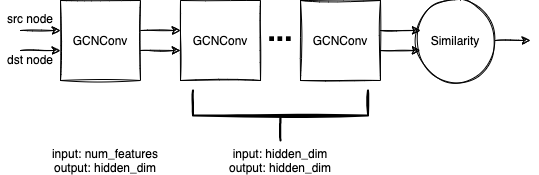

In [68]:
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn

In [69]:
class LinkPredictor(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim,
               num_graph_layers, dropout_pct):
    super(LinkPredictor, self).__init__()

    self.convs = nn.ModuleList()
    self.convs.append(pyg_nn.GCNConv(input_dim, hidden_dim))
    for i in range(num_graph_layers - 1):
      self.convs.append(pyg_nn.GCNConv(hidden_dim, hidden_dim))

    self.bns = nn.ModuleList()
    for i in range(num_graph_layers):
      self.bns.append(nn.BatchNorm1d(hidden_dim))

    self.num_graph_layers = num_graph_layers
    self.dropout_pct = dropout_pct

  def forward(self, data):
    x, edge_index, edge_label_index = data.x, data.edge_index, data.edge_label_index

    for i in range(self.num_graph_layers - 1):
      x = self.convs[i](x, edge_index)
      x = self.bns[0](x)
      x = F.dropout(x, p=self.dropout_pct)
      x = F.relu(x)
    x = self.convs[-1](x, edge_index)
    x = self.bns[-1](x)

    src_nodes = torch.index_select(x, 0, edge_label_index[0, :].long())
    dst_nodes = torch.index_select(x, 0, edge_label_index[1, :].long())
    x = torch.sum(src_nodes * dst_nodes, dim=-1)
    return x

  def loss(self, pred, label):
    return F.binary_cross_entropy_with_logits(pred, label)


In [70]:
model = LinkPredictor(dataset.num_features, 100, dataset.num_classes, 3, 0.5)
pred = model(train_dataset)
print(pred.size())

torch.Size([136])


### train_step

  1. In the `train_step` generate the predictions by running the `train_dataset` through the model, computing the loss, backpropagating the gradient of the loss and updating the model weights.
  2. Compute the AUC score for the entire dataset using the Scikit-Learn function [roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)
  3. Report the loss and AUC score over the entire dataset.

### eval_step

  1. Generate the predictions against the validation or test dataset using the current state of the model. As before, compute the loss and AUC score, but do not backpropagate.

### train_loop

  1. Run the `train_step` and `eval_step` over the required number of epochs.

In [71]:
from sklearn.metrics import roc_auc_score

In [74]:
def train_step(model, optimizer, train_dataset, device):
  model.train()
  train_dataset.to(device)
  optimizer.zero_grad()
  pred = model(train_dataset)
  label = train_dataset.edge_label
  loss = model.loss(pred, label)
  loss.backward()
  optimizer.step()
  auc = roc_auc_score(label.detach().cpu().numpy(), pred.detach().cpu().numpy())
  num_edges = len(train_dataset.edge_label)
  loss = loss.detach().numpy()
  return loss, auc

def eval_step(model, eval_dataset, device, is_validation=False):
  model.eval()
  eval_dataset.to(device)
  with torch.no_grad():
    pred = model(eval_dataset)
    label = eval_dataset.edge_label
    # print("pred:", pred)
    # print("label:", label)
    loss = model.loss(pred, label)
    auc = roc_auc_score(label.cpu().numpy(), pred.cpu().numpy())
    num_edges = len(eval_dataset.edge_label)
  return loss, auc

def train_loop(model, optimizer, train_dataset, val_dataset, device,
               num_epochs, log_every=10):
  history = []
  for epoch in range(num_epochs):
    train_loss, train_auc = train_step(model, optimizer, train_dataset, device)
    val_loss, val_auc = eval_step(model, val_dataset, device, is_validation=True)
    history.append((train_loss, train_auc, val_loss, val_auc))
    if epoch == 0 or (epoch + 1) % log_every == 0:
      print("EPOCH {:3d}, TRAIN loss: {:.5f}, AUC: {:.5f}, VAL loss: {:.5f}, AUC: {:.5f}"
        .format(epoch + 1, train_loss, train_auc, val_loss, val_auc))
  return history

## Train

Train the model using the hyperparameters listed below. Use the Adam optimizer. Plot the training plots.

In [75]:
# model parameters
INPUT_DIM = dataset.num_features
HIDDEN_DIM = 128
OUTPUT_DIM = dataset.num_classes
NUM_GCN_LAYERS = 3
DROPOUT_PCT = 0.5

# optimizer
LEARNING_RATE = 1e-2

NUM_EPOCHS = 100

In [76]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [77]:
model = LinkPredictor(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_GCN_LAYERS, DROPOUT_PCT)
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [78]:
history = train_loop(model, optimizer, train_dataset, val_dataset, device, NUM_EPOCHS)

EPOCH   1, TRAIN loss: 3.51460, AUC: 0.84213, VAL loss: 0.69061, AUC: 0.88889
EPOCH  10, TRAIN loss: 1.26807, AUC: 0.92409, VAL loss: 4.72746, AUC: 0.66667
EPOCH  20, TRAIN loss: 0.48537, AUC: 0.96670, VAL loss: 10.35253, AUC: 0.33333
EPOCH  30, TRAIN loss: 0.65400, AUC: 0.95415, VAL loss: 8.89749, AUC: 0.88889
EPOCH  40, TRAIN loss: 0.28644, AUC: 0.97189, VAL loss: 4.92720, AUC: 0.55556
EPOCH  50, TRAIN loss: 0.39707, AUC: 0.94961, VAL loss: 2.97779, AUC: 0.88889
EPOCH  60, TRAIN loss: 0.21224, AUC: 0.97881, VAL loss: 2.87097, AUC: 0.77778
EPOCH  70, TRAIN loss: 0.79769, AUC: 0.93837, VAL loss: 3.13942, AUC: 0.44444
EPOCH  80, TRAIN loss: 0.14979, AUC: 0.99048, VAL loss: 2.11577, AUC: 0.77778
EPOCH  90, TRAIN loss: 0.16755, AUC: 0.98465, VAL loss: 2.41693, AUC: 0.66667
EPOCH 100, TRAIN loss: 0.16297, AUC: 0.98594, VAL loss: 1.88452, AUC: 0.55556


In [79]:
import matplotlib.pyplot as plt
import numpy as np

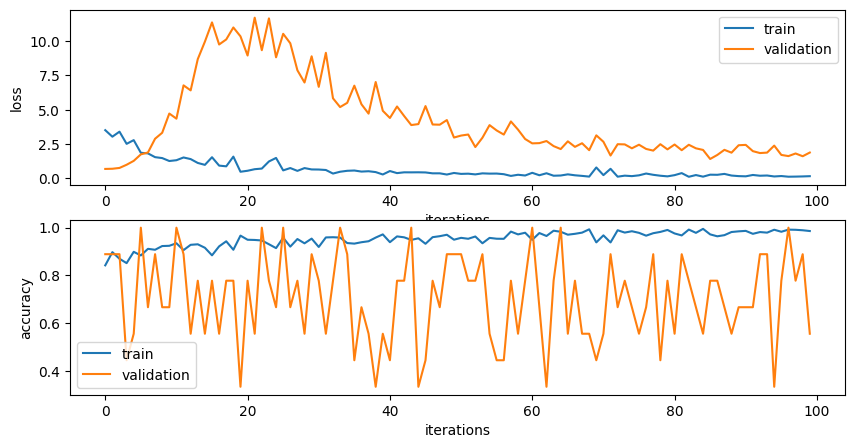

In [80]:
train_losses, train_accs, val_losses, val_accs = [], [], [], []
for train_loss, train_acc, val_loss, val_acc in history:
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

xs = np.arange(len(train_losses))

plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.plot(xs, train_losses, label="train")
plt.plot(xs, val_losses, label="validation")
plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend(loc="best")

plt.subplot(2, 1, 2)
plt.plot(xs, train_accs, label="train")
plt.plot(xs, val_accs, label="validation")
plt.xlabel("iterations")
plt.ylabel("accuracy")
plt.legend(loc="best")

## Evaluation

Evaluate the model against the `test_dataset` and report the AUC score.

In [82]:
from torch_geometric.utils import to_networkx
import networkx as nx

G = to_networkx(test_dataset, to_undirected=True)

In [93]:
dataset[0]

(Data(x=[34, 34], edge_index=[2, 136], y=[34], train_mask=[34], edge_label=[136], edge_label_index=[2, 136]),
 Data(x=[34, 34], edge_index=[2, 136], y=[34], train_mask=[34], edge_label=[6], edge_label_index=[2, 6]),
 Data(x=[34, 34], edge_index=[2, 142], y=[34], train_mask=[34], edge_label=[14], edge_label_index=[2, 14]))

In [91]:
test_dataset

Data(x=[34, 34], edge_index=[2, 142], y=[34], train_mask=[34], edge_label=[14], edge_label_index=[2, 14])

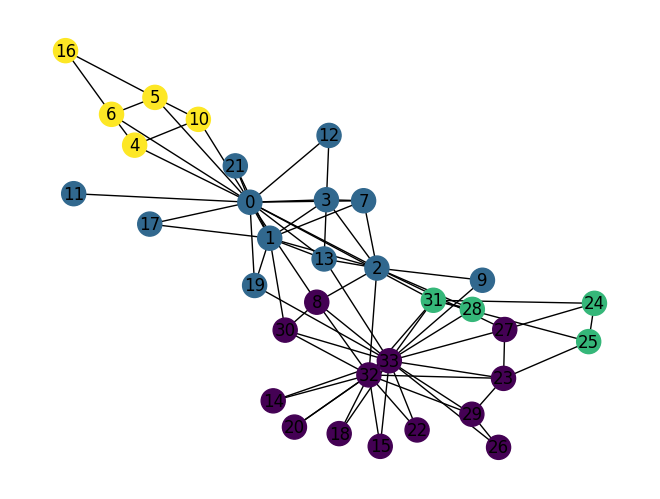

In [120]:
pos = nx.spring_layout(G, seed=37)
nx.draw(G, pos, with_labels=True, node_color=test_dataset.y.numpy())

In [94]:
_, test_auc = eval_step(model, test_dataset, device, is_validation=False)
print("Test AUC {:.5f}".format(test_auc))

Test AUC 0.69388


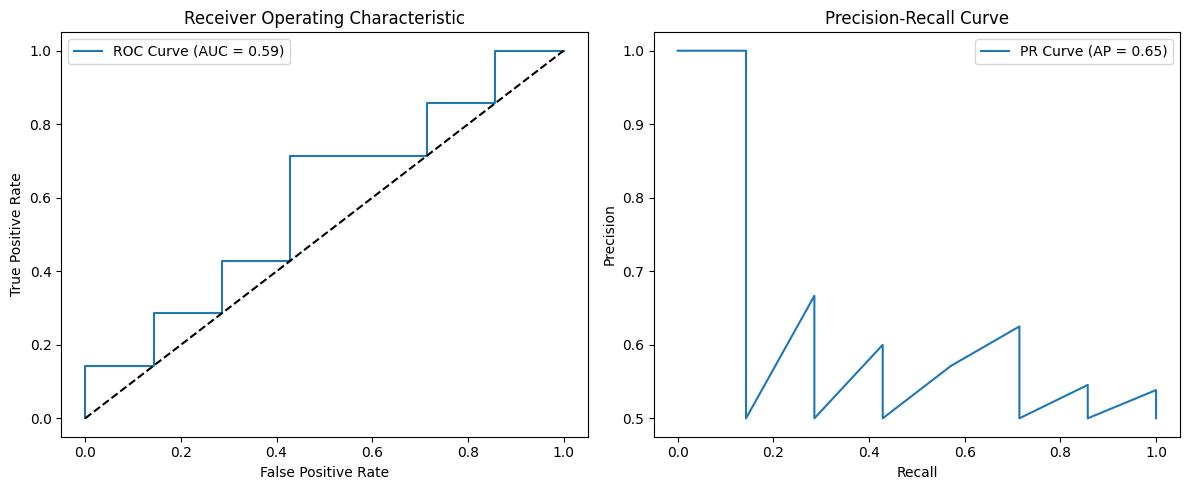


Test Set Evaluation Metrics:
ROC AUC: 0.5918
Average Precision: 0.6496
F1 Score: 0.6667
Accuracy: 0.5000
Precision: 1.0000
Recall: 0.5000

Top 10 Predicted Links:
1. Edge (0 -> 6): Predicted 0.9999, Actual 1.0, CORRECT
2. Edge (23 -> 6): Predicted 0.9978, Actual 0.0, INCORRECT
3. Edge (31 -> 33): Predicted 0.9978, Actual 1.0, CORRECT
4. Edge (25 -> 0): Predicted 0.9970, Actual 0.0, INCORRECT
5. Edge (4 -> 6): Predicted 0.9949, Actual 1.0, CORRECT
6. Edge (16 -> 11): Predicted 0.9921, Actual 0.0, INCORRECT
7. Edge (24 -> 25): Predicted 0.9883, Actual 1.0, CORRECT
8. Edge (22 -> 32): Predicted 0.9843, Actual 1.0, CORRECT
9. Edge (3 -> 26): Predicted 0.9821, Actual 0.0, INCORRECT
10. Edge (21 -> 32): Predicted 0.9810, Actual 0.0, INCORRECT


In [95]:
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

def evaluate_link_prediction(model, test_dataset, device):
    """
    Evaluate link prediction performance on test dataset
    Returns:
        - Dictionary containing evaluation metrics
        - Plots ROC curve and Precision-Recall curve
    """
    model.eval()
    test_dataset.to(device)

    with torch.no_grad():
        # Get predictions and true labels
        pred = model(test_dataset)
        pred_proba = torch.sigmoid(pred).cpu().numpy()  # Convert to probabilities
        true_labels = test_dataset.edge_label.cpu().numpy()

        # Calculate evaluation metrics
        from sklearn.metrics import (
            roc_auc_score,
            average_precision_score,
            precision_recall_curve,
            roc_curve,
            f1_score,
            accuracy_score
        )

        # Convert probabilities to binary predictions
        binary_pred = (pred_proba > 0.5).astype(int)

        metrics = {
            'roc_auc': roc_auc_score(true_labels, pred_proba),
            'average_precision': average_precision_score(true_labels, pred_proba),
            'f1_score': f1_score(true_labels, binary_pred),
            'accuracy': accuracy_score(true_labels, binary_pred),
            'precision': np.mean(binary_pred[true_labels == 1]),
            'recall': np.mean(true_labels[binary_pred == 1])
        }

        # Generate curves
        fpr, tpr, _ = roc_curve(true_labels, pred_proba)
        precision, recall, _ = precision_recall_curve(true_labels, pred_proba)

        # Plotting
        plt.figure(figsize=(12, 5))

        # ROC Curve
        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {metrics["roc_auc"]:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend()

        # Precision-Recall Curve
        plt.subplot(1, 2, 2)
        plt.plot(recall, precision,
                label=f'PR Curve (AP = {metrics["average_precision"]:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()

        plt.tight_layout()
        plt.show()

        return metrics, pred_proba, true_labels

# Example usage
test_metrics, test_pred_proba, test_true_labels = evaluate_link_prediction(model, test_dataset, device)

# Print metrics
print("\nTest Set Evaluation Metrics:")
print(f"ROC AUC: {test_metrics['roc_auc']:.4f}")
print(f"Average Precision: {test_metrics['average_precision']:.4f}")
print(f"F1 Score: {test_metrics['f1_score']:.4f}")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")

# Additional analysis: Top-k predicted links
def analyze_top_predictions(pred_proba, true_labels, edge_index, k=10):
    """
    Analyze top-k predicted links and their ground truth status
    """
    sorted_indices = np.argsort(-pred_proba)  # Sort descending
    top_k_indices = sorted_indices[:k]

    print(f"\nTop {k} Predicted Links:")
    for i, idx in enumerate(top_k_indices):
        src, dst = edge_index[:, idx]
        proba = pred_proba[idx]
        true_label = true_labels[idx]
        status = "CORRECT" if (proba > 0.5) == true_label else "INCORRECT"
        print(f"{i+1}. Edge ({src.item()} -> {dst.item()}): "
              f"Predicted {proba:.4f}, Actual {true_label}, {status}")

# Get the edge indices from test dataset
test_edge_index = test_dataset.edge_label_index
analyze_top_predictions(test_pred_proba, test_true_labels, test_edge_index, k=10)

Test Metrics: {'roc_auc': np.float64(0.5918367346938775), 'average_precision': np.float64(0.6595547309833023)}


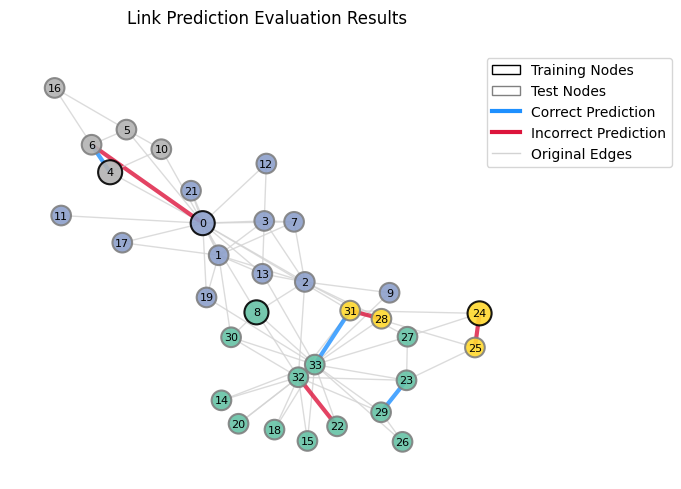

In [121]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


# Get original unsplit data for visualization
original_data = KarateClub()[0]
G = to_networkx(original_data, to_undirected=True)

# 2. Evaluation Function (from previous code)
def evaluate_link_prediction(model, test_dataset, device):
    model.eval()
    test_dataset.to(device)

    with torch.no_grad():
        pred = model(test_dataset)
        pred_proba = torch.sigmoid(pred).cpu().numpy()
        true_labels = test_dataset.edge_label.cpu().numpy()

        # Calculate metrics
        binary_pred = (pred_proba > 0.5).astype(int)
        metrics = {
            'roc_auc': roc_auc_score(true_labels, pred_proba),
            'average_precision': average_precision_score(true_labels, pred_proba),
        }

    return metrics, pred_proba, true_labels

# 3. Visualization Function
def visualize_link_predictions(original_data, test_data, test_pred_proba, test_true_labels, threshold=0.5):
    """
    Visualize link prediction results accounting for:
    - Original graph structure
    - Test edges (both positive and negative samples)
    - Prediction correctness
    - Node roles (train/test)
    """
    viz_graph = G.copy()

    # Get edge sets
    original_edges = set(zip(*original_data.edge_index.tolist()))
    test_edges = set(zip(*test_data.edge_label_index.tolist()))

    # Prepare edge visualization
    edge_colors = []
    edge_widths = []
    edge_styles = []

    for u, v in viz_graph.edges():
        if (u, v) in test_edges or (v, u) in test_edges:
            idx = list(test_edges).index((u, v)) if (u, v) in test_edges else list(test_edges).index((v, u))
            pred = (test_pred_proba[idx] > threshold)
            true = test_true_labels[idx]

            if pred == true:
                edge_colors.append('dodgerblue')  # Correct
                edge_widths.append(3)
            else:
                edge_colors.append('crimson')     # Incorrect
                edge_widths.append(3)
            edge_styles.append('solid')
        else:
            edge_colors.append('lightgray')        # Original
            edge_widths.append(1)
            edge_styles.append('solid')

    # Prepare node visualization
    node_colors = original_data.y.cpu().numpy()
    node_sizes = [300 if original_data.train_mask[i] else 200 for i in range(original_data.num_nodes)]
    node_borders = ['black' if original_data.train_mask[i] else 'gray' for i in range(original_data.num_nodes)]

    # Draw graph
    plt.figure(figsize=(7, 5))
    pos = nx.spring_layout(viz_graph, seed=37)

    nx.draw_networkx_nodes(
        viz_graph, pos,
        node_color=node_colors,
        cmap='Set2',
        node_size=node_sizes,
        edgecolors=node_borders,
        linewidths=1.5,
        alpha=0.9
    )

    nx.draw_networkx_edges(
        viz_graph, pos,
        edge_color=edge_colors,
        width=edge_widths,
        style=edge_styles,
        alpha=0.8
    )

    nx.draw_networkx_labels(viz_graph, pos, font_size=8)

    # Legend
    legend_elements = [
        Patch(facecolor='white', edgecolor='black', label='Training Nodes'),
        Patch(facecolor='white', edgecolor='gray', label='Test Nodes'),
        Line2D([0], [0], color='dodgerblue', lw=3, label='Correct Prediction'),
        Line2D([0], [0], color='crimson', lw=3, label='Incorrect Prediction'),
        Line2D([0], [0], color='lightgray', lw=1, label='Original Edges')
    ]

    plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.title("Link Prediction Evaluation Results", pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


# Evaluate and visualize
test_metrics, test_pred_proba, test_true_labels = evaluate_link_prediction(model, test_dataset, device)
print("Test Metrics:", test_metrics)
visualize_link_predictions(original_data, test_dataset, test_pred_proba, test_true_labels)